In [26]:
import yfinance as yf
import datetime as dt
import keras
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import CSVLogger
from keras.utils.vis_utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz 2.44.1\bin/'


def Percentage_Accuracy(y_true, y_pred):
    diff = keras.backend.abs(y_true-y_pred)
    correct = keras.backend.less(diff,0.03) 
    return keras.backend.mean(correct) 

In [27]:
data = yf.download("AAPL", start="2010-01-01", end="2020-01-01")

[*********************100%***********************]  1 of 1 completed


In [28]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.593426,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656428,6.604825,601904800
2010-01-06,7.656428,7.686786,7.526786,7.534643,6.499768,552160000
2010-01-07,7.562500,7.571429,7.466072,7.520714,6.487752,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.530883,447610800
...,...,...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497,70.459007,48478800
2019-12-26,71.205002,72.495003,71.175003,72.477501,71.856941,93121200
2019-12-27,72.779999,73.492500,72.029999,72.449997,71.829674,146266000


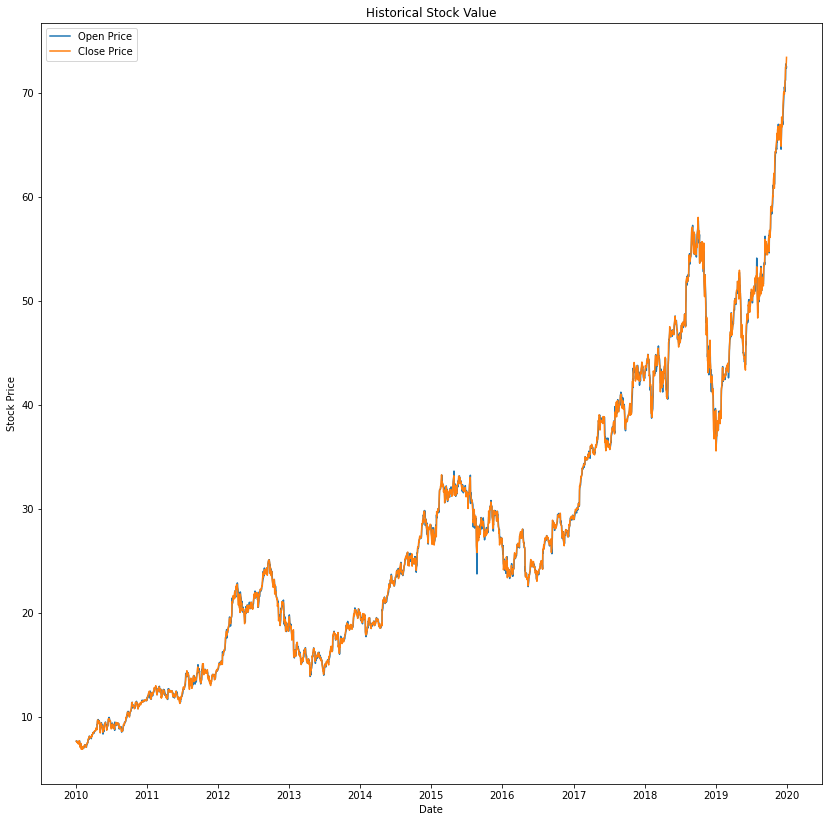

In [29]:
plt.figure(figsize=(14,14))
plt.plot(data['Open'], label='Open Price')
plt.plot(data['Close'], label='Close Price')
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [30]:
data['Date'] = data.index
filter_data = pd.DataFrame(columns = ['Date', 'Open','Volume','Close'])
sc_open = MinMaxScaler(feature_range = (-1, 1))
sc_close = MinMaxScaler(feature_range = (-1, 1))
sc_volume = MinMaxScaler(feature_range=(0,1))
filter_data['Date'] = data['Date']
filter_data['Open'] = sc_open.fit_transform(data.iloc[:,0:1].values)
filter_data['Volume'] = sc_volume.fit_transform(data.iloc[:,5:6].values)
filter_data['Close'] = sc_close.fit_transform(data.iloc[:,3:4].values)
filter_data.reset_index(drop=True)

,Date,Open,Volume,Close
0,2010-01-04,-0.977177,0.244222,-0.976431
1,2010-01-05,-0.975909,0.303155,-0.976034
2,2010-01-06,-0.976147,0.276055,-0.979694
3,2010-01-07,-0.978997,0.235179,-0.980113
4,2010-01-08,-0.980569,0.219097,-0.978610
...,...,...,...,...
2511,2019-12-24,0.951221,0.001651,0.929530
2512,2019-12-26,0.952207,0.025972,0.971902
2513,2019-12-27,1.000000,0.054925,0.971076
2514,2019-12-30,0.987407,0.053753,0.983998


In [31]:
#Training Data
num_entry_train_data = (int)(len(filter_data)*0.7)
X_train = np.empty([num_entry_train_data-30,30,2,1])
y_train = []
for i in range(30, num_entry_train_data):
    X_train[i-30,:,0,0] = filter_data.iloc[i-30:i, 1]
    X_train[i-30,:,1,0] = filter_data.iloc[i-30:i, 2]
    y_train.append(filter_data.iloc[i-30, 3])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],X_train.shape[2], 1))

In [32]:
#Test Data
num_entry_test_data = (len(filter_data) - num_entry_train_data)
X_test = np.empty([num_entry_test_data-30,30,2,1])
y_test = data.iloc[num_entry_train_data+30:,3:4].values
for i in range(30, num_entry_test_data):
    index_test = i+num_entry_train_data
    X_test[i-30,:,0,0] = filter_data.iloc[index_test-30:index_test, 1]
    X_test[i-30,:,1,0] = filter_data.iloc[index_test-30:index_test, 2]
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],X_test.shape[2], 1))

In [33]:
#Defining the LSTM Recurrent Model
regressor1 = Sequential()
regressor1.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor1.add(Dropout(0.2))
regressor1.add(LSTM(units = 50, return_sequences = True))
regressor1.add(Dropout(0.2))
regressor1.add(LSTM(units = 50, return_sequences = True))
regressor1.add(Dropout(0.2))
regressor1.add(LSTM(units = 50))
regressor1.add(Dropout(0.2))
regressor1.add(Dense(units = 1))

regressor2 = Sequential()
regressor2.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor2.add(Dropout(0.2))
regressor2.add(LSTM(units = 50, return_sequences = True))
regressor2.add(Dropout(0.2))
regressor2.add(LSTM(units = 50, return_sequences = True))
regressor2.add(Dropout(0.2))
regressor2.add(LSTM(units = 50))
regressor2.add(Dropout(0.2))
regressor2.add(Dense(units = 1))

mergeout = keras.layers.Multiply()([regressor1.output,regressor2.output])

regressor = keras.Model([regressor1.input,regressor2.input],mergeout)

In [34]:
regressor.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_16_input (InputLayer)      [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
lstm_20_input (InputLayer)      [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
lstm_16 (LSTM)                  (None, 30, 50)       10400       lstm_16_input[0][0]              
__________________________________________________________________________________________________
lstm_20 (LSTM)                  (None, 30, 50)       10400       lstm_20_input[0][0]              
____________________________________________________________________________________________

In [35]:
plot_model(regressor, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [77]:
#Compiling and fitting the model
csv_logger = CSVLogger("model_history_log.csv")
opt = keras.optimizers.Adamax()
lossfunction = keras.losses.mse
regressor.compile(optimizer = opt, loss = lossfunction, metrics=[Percentage_Accuracy])

regressor.fit([ X_train[:,:,0],X_train[:,:,1] ], y_train, epochs = 50, batch_size =16 ,callbacks=[csv_logger], validation_split=0.2)

Epoch 1/50
87/87 [==============================] - 32s 122ms/step - loss: 0.2592 - Percentage_Accuracy: 0.0646 - val_loss: 0.0034 - val_Percentage_Accuracy: 0.3639
Epoch 2/50
87/87 [==============================] - 7s 80ms/step - loss: 0.0165 - Percentage_Accuracy: 0.2057 - val_loss: 0.0029 - val_Percentage_Accuracy: 0.3613
Epoch 3/50
87/87 [==============================] - 7s 76ms/step - loss: 0.0155 - Percentage_Accuracy: 0.2012 - val_loss: 0.0027 - val_Percentage_Accuracy: 0.4362
Epoch 4/50
87/87 [==============================] - 7s 76ms/step - loss: 0.0112 - Percentage_Accuracy: 0.2308 - val_loss: 0.0021 - val_Percentage_Accuracy: 0.4321
Epoch 5/50
87/87 [==============================] - 6s 73ms/step - loss: 0.0105 - Percentage_Accuracy: 0.2604 - val_loss: 0.0023 - val_Percentage_Accuracy: 0.5114
Epoch 6/50
87/87 [==============================] - 6s 73ms/step - loss: 0.0088 - Percentage_Accuracy: 0.2647 - val_loss: 0.0046 - val_Percentage_Accuracy: 0.3376
Epoch 7/50
87/87 [==

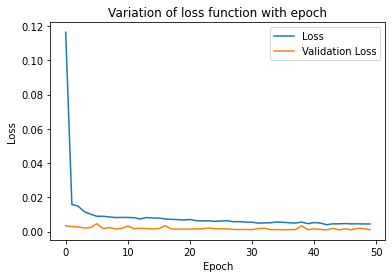

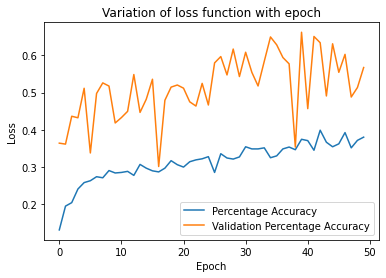

In [78]:
model_log_data = pd.read_csv("model_history_log.csv")
plt.plot(model_log_data["epoch"].values, model_log_data["loss"].values, label = "Loss")
plt.plot(model_log_data["epoch"].values, model_log_data["val_loss"].values, label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Variation of loss function with epoch')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()
plt.plot(model_log_data["epoch"].values, model_log_data["Percentage_Accuracy"].values, label = "Percentage Accuracy")
plt.plot(model_log_data["epoch"].values, model_log_data["val_Percentage_Accuracy"].values, label = "Validation Percentage Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Variation of loss function with epoch')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [79]:
predicted_value = regressor.predict([ X_test[:,:,0],X_test[:,:,1]])

In [80]:
predicted_value = sc_close.inverse_transform(predicted_value)

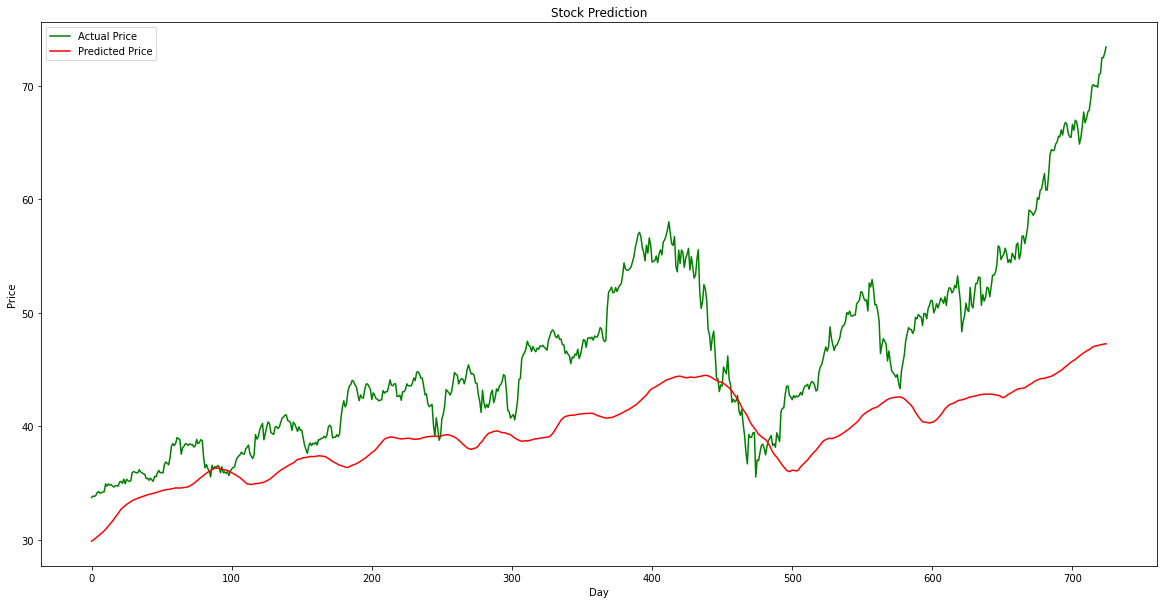

In [81]:
plt.figure(figsize=(20,10))
plt.plot(y_test, color = 'green', label = 'Actual Price')
plt.plot(predicted_value, color = 'red', label = 'Predicted Price')
plt.title('Stock Prediction')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()